# Construction of index from firm characteristics

This notebook builds a column index for each stock at a given date based on its firm's monthly characteristics. 
The approach uses partial least squares (PLS) trained on monthly cumulative returns to build the column index, capturing the most variation possible. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import rankdata
import gc

## Step 1: From daily returns, compute cumulative returns over every month and stock 

In [2]:
firms = pd.read_csv('Predictors/CompFirmCharac_sanitized.csv')
firms

,date,gvkey,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,dilady,...,opepsy,piy,revty,saley,spiy,sstky,txty,xidoy,xiy,xopry
0,2000-01-31,1013,0.0,46.785,21.138,291.300,182.525,174.925,0.0,0.0,...,0.31,68.400,593.900,593.900,0.000,42.657,15.300,0.000,0.0,496.900
1,2000-01-31,1082,0.0,9.597,-2.956,117.073,2.936,2.936,0.0,0.0,...,0.31,1.503,131.177,131.177,0.000,0.000,0.590,-2.563,0.0,123.541
2,2000-01-31,1173,0.0,0.558,-0.754,14.390,3.937,3.937,0.0,0.0,...,0.07,0.482,23.271,23.271,0.000,0.000,0.222,0.000,0.0,21.847
3,2000-01-31,1183,0.0,1.091,22.224,9.732,28.169,28.169,0.0,0.0,...,-0.13,-17.342,7.476,7.476,-15.974,0.000,-3.286,0.741,0.0,9.732
4,2000-01-31,1189,0.0,17.181,-12.630,724.161,31.445,30.435,0.0,0.0,...,0.57,31.030,779.820,779.820,0.000,0.000,12.136,-0.007,0.0,724.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871753,2024-12-31,351491,0.0,972.159,843.780,12427.891,271.000,267.000,0.0,0.0,...,2.17,629.470,15828.894,15828.894,-150.121,0.000,72.472,-192.568,0.0,13815.210
871754,2024-12-31,351590,0.0,1467.038,-532.151,43200.489,1592.000,1592.000,0.0,0.0,...,2.40,3936.259,55986.599,55986.599,-499.021,0.000,761.991,0.000,0.0,50543.961
871755,2024-12-31,352262,0.0,187.490,28.382,77.330,53.701,53.701,0.0,0.0,...,1.83,101.077,338.497,338.497,0.000,0.000,0.277,0.000,0.0,99.266
871756,2024-12-31,356128,0.0,182.467,-383.127,635.416,191.430,189.832,0.0,0.0,...,10.44,2444.223,4826.644,4826.644,0.000,0.000,429.749,0.000,0.0,1153.056


In [3]:
firms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871758 entries, 0 to 871757
Data columns (total 43 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    871758 non-null  object 
 1   gvkey   871758 non-null  int64  
 2   acchgy  871758 non-null  float64
 3   capxy   871758 non-null  float64
 4   chechy  871758 non-null  float64
 5   cogsy   871758 non-null  float64
 6   cshfdy  871758 non-null  float64
 7   cshpry  871758 non-null  float64
 8   cstkey  871758 non-null  float64
 9   dilady  871758 non-null  float64
 10  dilavy  871758 non-null  float64
 11  doy     871758 non-null  float64
 12  dvpy    871758 non-null  float64
 13  dvy     871758 non-null  float64
 14  epsfiy  871758 non-null  float64
 15  epsfxy  871758 non-null  float64
 16  epspiy  871758 non-null  float64
 17  epspxy  871758 non-null  float64
 18  exrey   871758 non-null  float64
 19  fiaoy   871758 non-null  float64
 20  fincfy  871758 non-null  float64
 21  ibadjy  87

In [3]:
daily = pd.read_csv('Targets/daily_crsp_sanitized.csv', usecols=['date', 'PERMCO', 'PERMNO', 'DlyRet'])

In [4]:
daily

,date,PERMCO,PERMNO,DlyRet
0,2000-01-03,5,15580,0.000000
1,2000-01-03,7,14593,0.088754
2,2000-01-03,25,62770,-0.061489
3,2000-01-03,29,59184,-0.012346
4,2000-01-03,33,59248,-0.034524
...,...,...,...,...
46688522,2024-12-31,60118,26023,-0.000393
46688523,2024-12-31,60120,26027,-0.194924
46688524,2024-12-31,60121,26034,0.108590
46688525,2024-12-31,60122,26035,-0.034979


In [6]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46688527 entries, 0 to 46688526
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   PERMCO  int64  
 2   PERMNO  int64  
 3   DlyRet  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ GB


In [4]:
linking = pd.read_csv('linking_table_sanitized.csv')
linking

,gvkey,LINKTYPE,PERMNO,PERMCO,LINKDT,LINKENDDT
0,1000,LU,25881,23369,1970-11-13,1978-06-30
1,1001,LU,10015,6398,1983-09-20,1986-07-31
2,1002,LC,10023,22159,1972-12-14,1973-06-05
3,1003,LU,10031,6672,1983-12-07,1989-08-16
4,1004,LU,54594,20000,1972-04-24,2099-12-31
...,...,...,...,...,...,...
33380,352262,LC,23773,59507,2023-03-17,2099-12-31
33381,353444,LC,23209,59330,2022-07-22,2099-12-31
33382,355398,LC,25134,59886,2024-05-17,2099-12-31
33383,356128,LC,24704,59765,2024-01-19,2099-12-31


In [8]:
# Ensure datetime 
daily['date'] = pd.to_datetime(daily['date'])

# Add a 'year_month' column
daily['year_month'] = daily['date'].dt.to_period('M')

# Group by PERMNO and year_month, then calculate cumulative return
monthly_cumret = (
    daily.groupby(['PERMNO', 'year_month'])['DlyRet']
    .apply(lambda x: (1 + x).prod() - 1)
    .reset_index()
)

# Convert year_month back to timestamp for sorting
monthly_cumret['date'] = monthly_cumret['year_month'].dt.to_timestamp()

# Sort by date and PERMNO
monthly_cumret = monthly_cumret.sort_values(['date', 'PERMNO'])

# Rename for clarity
monthly_cumret = monthly_cumret.rename(columns={'DlyRet': 'MonthlyRet'})
monthly_cumret

,PERMNO,year_month,MonthlyRet,date
0,10001,2000-01,-0.044118,2000-01-01
212,10002,2000-01,-0.025640,2000-01-01
370,10009,2000-01,-0.008475,2000-01-01
381,10012,2000-01,-0.097276,2000-01-01
449,10016,2000-01,-0.099339,2000-01-01
...,...,...,...,...
2241066,93426,2024-12,0.021768,2024-12-01
2241241,93427,2024-12,-0.062666,2024-12-01
2241509,93429,2024-12,-0.094742,2024-12-01
2241842,93434,2024-12,0.133332,2024-12-01


In [9]:
monthly_cumret = monthly_cumret.drop(columns=['year_month']) # No longer needed
monthly_cumret

,PERMNO,MonthlyRet,date
0,10001,-0.044118,2000-01-01
212,10002,-0.025640,2000-01-01
370,10009,-0.008475,2000-01-01
381,10012,-0.097276,2000-01-01
449,10016,-0.099339,2000-01-01
...,...,...,...
2241066,93426,0.021768,2024-12-01
2241241,93427,-0.062666,2024-12-01
2241509,93429,-0.094742,2024-12-01
2241842,93434,0.133332,2024-12-01


In [10]:
monthly_cumret.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2242042 entries, 0 to 2242041
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   PERMNO      int64         
 1   MonthlyRet  float64       
 2   date        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 68.4 MB


In [11]:
monthly_cumret.to_csv('Predictors/monthly_cum_ret.csv')

## Step 2: Merge monthly returns with firm characteristics

In [5]:
monthly_cumret = pd.read_csv('Predictors/monthly_cum_ret.csv')
monthly_cumret

,Unnamed: 0,PERMNO,MonthlyRet,date
0,0,10001,-0.044118,2000-01-01
1,212,10002,-0.025640,2000-01-01
2,370,10009,-0.008475,2000-01-01
3,381,10012,-0.097276,2000-01-01
4,449,10016,-0.099339,2000-01-01
...,...,...,...,...
2242037,2241066,93426,0.021768,2024-12-01
2242038,2241241,93427,-0.062666,2024-12-01
2242039,2241509,93429,-0.094742,2024-12-01
2242040,2241842,93434,0.133332,2024-12-01


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
import tqdm

def memory_efficient_merge(linking_df_path, characteristics_df_path, returns_df_path, output_path=None):
    """
    Memory-efficient merging of firm characteristics with returns using linking table.
    
    Parameters:
    - linking_df_path: Path to linking table CSV
    - characteristics_df_path: Path to firm characteristics CSV
    - returns_df_path: Path to monthly returns CSV
    - output_path: Optional path to save merged output
    
    Returns:
    - Merged DataFrame (if output_path=None) or None (if output saved to file)
    """
    
    # 1. Process linking table first (smallest in memory)
    print("Loading linking table...")
    link_dtypes = {
        'gvkey': 'int32',
        'LINKTYPE': 'category',
        'PERMNO': 'int32',
        'PERMCO': 'int32',
        'LINKDT': 'str',
        'LINKENDDT': 'str'
    }
    linking_df = pd.read_csv(linking_df_path, dtype=link_dtypes)
    
    # Convert date columns to datetime
    linking_df['LINKDT'] = pd.to_datetime(linking_df['LINKDT'])
    linking_df['LINKENDDT'] = pd.to_datetime(linking_df['LINKENDDT'])
    
    # Create mapping dictionaries
    gvkey_to_permno = linking_df.set_index('gvkey')['PERMNO'].to_dict()
    permno_to_gvkey = linking_df.set_index('PERMNO')['gvkey'].to_dict()
    
    # 2. Process returns in chunks (largest dataset)
    print("Processing returns in chunks...")
    ret_dtypes = {
        'PERMNO': 'int32',
        'MonthlyRet': 'float32',
        'date': 'str'
    }
    
    # Initialize empty list to store merged chunks
    merged_chunks = []
    chunksize = 100000  # Adjust based on memory constraints
    
    # First pass: verify we can find matches
    test_ret_chunk = next(pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=100))
    test_ret_chunk['date'] = pd.to_datetime(test_ret_chunk['date'])
    test_ret_chunk['gvkey'] = test_ret_chunk['PERMNO'].map(permno_to_gvkey)
    
    print(f"Sample returns with gvkey mapping:\n{test_ret_chunk.head()}")
    print(f"Number of returns with valid gvkey: {test_ret_chunk['gvkey'].notna().sum()}")
    
    # Second pass: process characteristics to verify format
    test_char_chunk = next(pd.read_csv(characteristics_df_path, chunksize=100))
    test_char_chunk['date'] = pd.to_datetime(test_char_chunk['date'])
    print(f"Characteristics date range: {test_char_chunk['date'].min()} to {test_char_chunk['date'].max()}")
    
    # Full processing if test passes
    for ret_chunk in tqdm(pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=chunksize)):
        # Convert date column and ensure proper format
        ret_chunk['date'] = pd.to_datetime(ret_chunk['date'])
        ret_chunk['year_month'] = ret_chunk['date'].dt.to_period('M')
        
        # Map PERMNO to gvkey
        ret_chunk['gvkey'] = ret_chunk['PERMNO'].map(permno_to_gvkey)
        ret_chunk = ret_chunk[ret_chunk['gvkey'].notna()]
        
        if ret_chunk.empty:
            print("Warning: Empty returns chunk after gvkey mapping")
            continue
            
        ret_chunk['gvkey'] = ret_chunk['gvkey'].astype('int32')
        
        # Process characteristics in chunks
        for char_chunk in pd.read_csv(characteristics_df_path, chunksize=chunksize):
            char_chunk['date'] = pd.to_datetime(char_chunk['date'])
            char_chunk['year_month'] = char_chunk['date'].dt.to_period('M')
            
            # Merge on gvkey and year-month (more efficient than exact date)
            merged = pd.merge(
                ret_chunk,
                char_chunk,
                on=['gvkey', 'year_month'],
                how='inner'
            )
            
            if not merged.empty:
                merged_chunks.append(merged)
        
        # Clear memory
        gc.collect()
    
    if not merged_chunks:
        raise ValueError("No successful merges occurred. Check your data compatibility.")
    
    # Concatenate all merged chunks
    print("Concatenating merged chunks...")
    final_df = pd.concat(merged_chunks, ignore_index=True)
    
    # Drop temporary column and optimize memory
    final_df.drop(columns=['year_month'], inplace=True, errors='ignore')
    final_df = reduce_memory_usage(final_df)
    
    # Save or return result
    if output_path:
        print(f"Saving merged data to {output_path}...")
        final_df.to_csv(output_path, index=False)
        return None
    else:
        return final_df

def reduce_memory_usage(df):
    """Reduce memory usage of DataFrame by downcasting numeric columns"""
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'object':
            if df[col].nunique() / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')
    
    return df



In [14]:
# Run with garbage collection
gc.collect()
merged_data = memory_efficient_merge(
    linking_df_path='linking_table_sanitized.csv',
    characteristics_df_path='Predictors/CompFirmCharac_sanitized.csv',
    returns_df_path='Predictors/monthly_cum_ret.csv',
    output_path='Predictors/merged_data.csv'
)



Loading linking table...
Processing returns in chunks...
Sample returns with gvkey mapping:
   Unnamed: 0  PERMNO  MonthlyRet       date  gvkey
0           0   10001   -0.044118 2000-01-01  12994
1         212   10002   -0.025640 2000-01-01  19049
2         370   10009   -0.008475 2000-01-01  16739
3         381   10012   -0.097276 2000-01-01  11907
4         449   10016   -0.099339 2000-01-01   4641
Number of returns with valid gvkey: 100
Characteristics date range: 2000-01-31 00:00:00 to 2000-01-31 00:00:00
Concatenating merged chunks...
Saving merged data to Predictors/merged_data.csv...


## Step 3: Train PLS and extract index

In [7]:
merged = pd.read_csv('Predictors/merged_data.csv')
merged

,Unnamed: 0,PERMNO,MonthlyRet,date_x,gvkey,date_y,acchgy,capxy,chechy,cogsy,...,opepsy,piy,revty,saley,spiy,sstky,txty,xidoy,xiy,xopry
0,496,10025,2.378650e-01,2000-01-01,11903,2000-01-31,0.0,3.932,0.439,127.540,...,-0.15,-1.954,163.846,163.846,0.000,0.349,-0.801,0.000,0.0,152.177
1,3070,10089,-4.166620e-02,2000-01-01,12143,2000-01-31,0.0,0.314,-0.152,8.855,...,0.19,1.235,13.185,13.185,0.000,0.050,0.000,0.380,0.0,11.059
2,5798,10155,5.000001e-01,2000-01-01,12094,2000-01-31,0.0,0.085,0.125,4.519,...,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.000,0.0,6.169
3,6483,10182,-1.785708e-01,2000-01-01,12171,2000-01-31,0.0,59.038,23.171,16000.244,...,2.47,200.754,16991.750,16991.750,0.000,24.854,72.837,0.000,0.0,16662.036
4,9396,10256,-8.278109e-07,2000-01-01,12226,2000-01-31,0.0,0.045,-1.493,2.854,...,0.01,0.017,4.167,4.167,0.000,0.014,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518548,2241066,93426,2.176763e-02,2024-12-01,185138,2024-12-31,0.0,9.163,-4.693,165.106,...,0.82,17.564,306.522,306.522,-1.242,0.000,7.730,0.000,0.0,272.611
518549,2241241,93427,-6.266588e-02,2024-12-01,179583,2024-12-31,0.0,42.150,-6.402,1412.165,...,4.54,175.648,1637.836,1637.836,-0.103,0.000,11.618,0.000,0.0,1455.402
518550,2241509,93429,-9.474157e-02,2024-12-01,184500,2024-12-31,0.0,60.900,368.700,2022.100,...,8.08,1083.800,4093.500,4093.500,-111.400,8.600,318.900,0.000,0.0,2776.600
518551,2241842,93434,1.333318e-01,2024-12-01,184259,2024-12-31,0.0,0.195,1.107,10.167,...,-5.21,-12.486,13.386,13.386,-0.840,0.000,0.003,-5.402,0.0,19.591


In [8]:
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import rankdata

def process_chunk(chunk):
    """
    Helper function to process a single chunk by rank-transforming each column.
    
    Parameters:
    -----------
    chunk : pd.DataFrame
        Input data chunk to process
        
    Returns:
    --------
    pd.DataFrame
        Processed chunk with rank-normalized values
    """
    chunk_processed = chunk.copy()
    for col in chunk.columns:
        x = chunk[col]
        non_missing = x.notna()
        x_non_missing = x[non_missing]
        
        if len(x_non_missing) > 0:
            ranks = rankdata(x_non_missing, method='average') - 1
            normalized = ranks / len(x_non_missing) - 0.5
            chunk_processed.loc[non_missing, col] = normalized
        
        chunk_processed.loc[~non_missing, col] = 0  # Impute missing with 0
    
    return chunk_processed

def preprocess_characteristics_with_pls(X_raw, y_raw, missing_threshold=0.3):
    """
    Preprocess firm characteristics and apply PLS for a single-value index without look-ahead bias.
    
    Parameters:
    -----------
    X_raw : pd.DataFrame
        Signal data with columns ['PERMNO', 'gvkey', 'date', ...features...]
    y_raw : pd.DataFrame  
        Target data with columns ['date', 'gvkey', 'MonthlyRet']
    missing_threshold : float, default=0.3
        Maximum fraction of missing values allowed per observation
        
    Returns:
    --------
    tuple
        (index_df, pls_models) where:
        - index_df: DataFrame with PLS index values
        - pls_models: Dictionary of fitted PLSRegression models by date
    """
    # Ensure dates are sorted chronologically
    dates = np.sort(X_raw['date'].unique())
    results = []
    pls_models = {}
    
    for i, date in enumerate(dates):
        # For each date, we'll use only prior data to train PLS
        prior_dates = dates[:i]
        
        # First pass: collect and align prior data for PLS training
        all_chunks = []
        all_targets = []
        
        for prior_date in prior_dates:
            # Filter data for prior date
            date_mask = X_raw['date'] == prior_date
            date_chunk = X_raw[date_mask].copy()
            
            # Extract features (drop identifier columns)
            X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
            
            # Filter out observations with too many missing values
            missing_frac = X_date.isna().mean(axis=1)
            eligible_mask = missing_frac <= missing_threshold
            
            if not eligible_mask.any():
                continue
            
            # Process eligible observations
            X_eligible = X_date[eligible_mask]
            gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
            X_processed = process_chunk(X_eligible)
            
            # Match with target data - only keep firms that exist in both datasets
            y_date = y_raw[(y_raw['date'] == prior_date) & (y_raw['gvkey'].isin(gvkeys))]
            
            if len(y_date) == 0:
                continue
                
            # Find intersection of gvkeys that exist in both datasets
            common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
            
            if len(common_gvkeys) == 0:
                continue
            
            # Filter features to only include firms with returns
            gvkey_mask = np.isin(gvkeys, common_gvkeys)
            X_processed_filtered = X_processed[gvkey_mask]
            
            # Get corresponding target values in same order
            y_date_indexed = y_date.set_index('gvkey')
            y_vals = y_date_indexed.loc[common_gvkeys]['MonthlyRet'].values
            
            all_chunks.append(X_processed_filtered)
            all_targets.append(y_vals)
        
        # Fit PLS model on all prior aligned data (if any exists)
        if len(all_chunks) > 0:
            X_all_df = pd.concat(all_chunks)
            X_all = X_all_df.values
            y_all = np.concatenate(all_targets)
            
            print(f"Training PLS for date {date} with {len(X_all)} prior observations")
            
            pls = PLSRegression(n_components=1)
            pls.fit(X_all_df, y_all)
            pls_models[date] = pls
        else:
            print(f"No prior data available for date {date}, skipping")
            continue
        
        # Second pass: apply trained PLS model to generate index for current date
        date_mask = X_raw['date'] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features
        X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
        permnos = date_chunk.loc[eligible_mask, 'PERMNO'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data
        y_date = y_raw[(y_raw['date'] == date) & (y_raw['gvkey'].isin(gvkeys))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of gvkeys
        common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
        
        if len(common_gvkeys) == 0:
            continue
        
        # Filter to only include firms with returns
        gvkey_mask = np.isin(gvkeys, common_gvkeys)
        X_processed_filtered = X_processed[gvkey_mask]
        common_gvkeys_filtered = gvkeys[gvkey_mask]
        common_permnos_filtered = permnos[gvkey_mask]
        
        # Generate PLS index (first component score)
        index_values = pls.transform(X_processed_filtered)[:, 0]
        
        # Store results
        result_df = pd.DataFrame({
            'date': date,
            'PERMNO': common_permnos_filtered,
            'gvkey': common_gvkeys_filtered,
            'pls_index': index_values
        })
        results.append(result_df)
    
    # Combine all results
    index_df = pd.concat(results, ignore_index=True)
    
    print(f"Generated PLS index for {len(index_df)} firm-date observations")
    
    return index_df, pls_models

In [9]:
returns = merged[['date_y', 'gvkey', 'MonthlyRet']].copy()
returns = returns.rename(columns={'date_y': 'date'})
returns['date'] = pd.to_datetime(returns['date'])
returns

,date,gvkey,MonthlyRet
0,2000-01-31,11903,2.378650e-01
1,2000-01-31,12143,-4.166620e-02
2,2000-01-31,12094,5.000001e-01
3,2000-01-31,12171,-1.785708e-01
4,2000-01-31,12226,-8.278109e-07
...,...,...,...
518548,2024-12-31,185138,2.176763e-02
518549,2024-12-31,179583,-6.266588e-02
518550,2024-12-31,184500,-9.474157e-02
518551,2024-12-31,184259,1.333318e-01


In [10]:
merged = merged.drop(['Unnamed: 0', 'MonthlyRet', 'date_x'], axis=1)
merged = merged.rename(columns={'date_y': 'date'})
merged['date'] = pd.to_datetime(merged['date'])
merged

,PERMNO,gvkey,date,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,opepsy,piy,revty,saley,spiy,sstky,txty,xidoy,xiy,xopry
0,10025,11903,2000-01-31,0.0,3.932,0.439,127.540,7.567,7.443,0.0,...,-0.15,-1.954,163.846,163.846,0.000,0.349,-0.801,0.000,0.0,152.177
1,10089,12143,2000-01-31,0.0,0.314,-0.152,8.855,7.091,6.578,0.0,...,0.19,1.235,13.185,13.185,0.000,0.050,0.000,0.380,0.0,11.059
2,10155,12094,2000-01-31,0.0,0.085,0.125,4.519,9.378,8.343,0.0,...,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.000,0.0,6.169
3,10182,12171,2000-01-31,0.0,59.038,23.171,16000.244,58.508,51.693,0.0,...,2.47,200.754,16991.750,16991.750,0.000,24.854,72.837,0.000,0.0,16662.036
4,10256,12226,2000-01-31,0.0,0.045,-1.493,2.854,6.979,6.979,0.0,...,0.01,0.017,4.167,4.167,0.000,0.014,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518548,93426,185138,2024-12-31,0.0,9.163,-4.693,165.106,13.386,13.353,0.0,...,0.82,17.564,306.522,306.522,-1.242,0.000,7.730,0.000,0.0,272.611
518549,93427,179583,2024-12-31,0.0,42.150,-6.402,1412.165,36.405,36.183,0.0,...,4.54,175.648,1637.836,1637.836,-0.103,0.000,11.618,0.000,0.0,1455.402
518550,93429,184500,2024-12-31,0.0,60.900,368.700,2022.100,105.500,105.100,-3.9,...,8.08,1083.800,4093.500,4093.500,-111.400,8.600,318.900,0.000,0.0,2776.600
518551,93434,184259,2024-12-31,0.0,0.195,1.107,10.167,2.287,2.287,0.0,...,-5.21,-12.486,13.386,13.386,-0.840,0.000,0.003,-5.402,0.0,19.591


In [12]:
index_df, pls_model = preprocess_characteristics_with_pls(merged, returns)
index_df

No prior data available for date 2000-01-31T00:00:00.000000000, skipping
Training PLS for date 2000-02-29T00:00:00.000000000 with 569 prior observations
Training PLS for date 2000-03-31T00:00:00.000000000 with 914 prior observations
Training PLS for date 2000-04-30T00:00:00.000000000 with 7162 prior observations
Training PLS for date 2000-05-31T00:00:00.000000000 with 7730 prior observations
Training PLS for date 2000-06-30T00:00:00.000000000 with 8064 prior observations
Training PLS for date 2000-07-31T00:00:00.000000000 with 14301 prior observations
Training PLS for date 2000-08-31T00:00:00.000000000 with 14863 prior observations
Training PLS for date 2000-09-30T00:00:00.000000000 with 15189 prior observations
Training PLS for date 2000-10-31T00:00:00.000000000 with 21444 prior observations
Training PLS for date 2000-11-30T00:00:00.000000000 with 21991 prior observations
Training PLS for date 2000-12-31T00:00:00.000000000 with 22307 prior observations
Training PLS for date 2001-01-31

,date,PERMNO,gvkey,pls_index
0,2000-02-29,10012,11907,-0.558490
1,2000-02-29,10044,11976,-0.733652
2,2000-02-29,10087,13119,-0.550391
3,2000-02-29,10104,12142,1.712691
4,2000-02-29,10114,14524,0.622023
...,...,...,...,...
517979,2024-12-31,93426,185138,-0.082229
517980,2024-12-31,93427,179583,3.241115
517981,2024-12-31,93429,184500,4.519229
517982,2024-12-31,93434,184259,-3.565967


## Step 4: Inspect index to determine correlation with stock returns

Analyzing 299 PLS models from 2000-02-29T00:00:00.000000000 to 2024-12-31T00:00:00.000000000

MODEL INSPECTION FOR DATE: 2000-02-29T00:00:00.000000000
Number of components: 1
Number of features: 41
Feature names available: Yes (41 features)

Top 25 most important features:
feature   loading  abs_loading       date
  fiaoy  0.489794     0.489794 2000-02-29
    dvy -0.362392     0.362392 2000-02-29
 chechy -0.325766     0.325766 2000-02-29
 dilady -0.276424     0.276424 2000-02-29
 ivacoy -0.238035     0.238035 2000-02-29
 fincfy  0.232453     0.232453 2000-02-29
  xopry  0.199293     0.199293 2000-02-29
  cogsy  0.194831     0.194831 2000-02-29
  saley  0.170115     0.170115 2000-02-29
  revty  0.169376     0.169376 2000-02-29
 cshpry  0.154281     0.154281 2000-02-29
    doy  0.146614     0.146614 2000-02-29
  nopiy  0.146205     0.146205 2000-02-29
   dvpy -0.138975     0.138975 2000-02-29
 cshfdy  0.128930     0.128930 2000-02-29
   spiy  0.126654     0.126654 2000-02-29
  sstky  0.1

/tmp/ipykernel_238198/3699135434.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features_counts = combined_loadings.groupby('feature').apply(


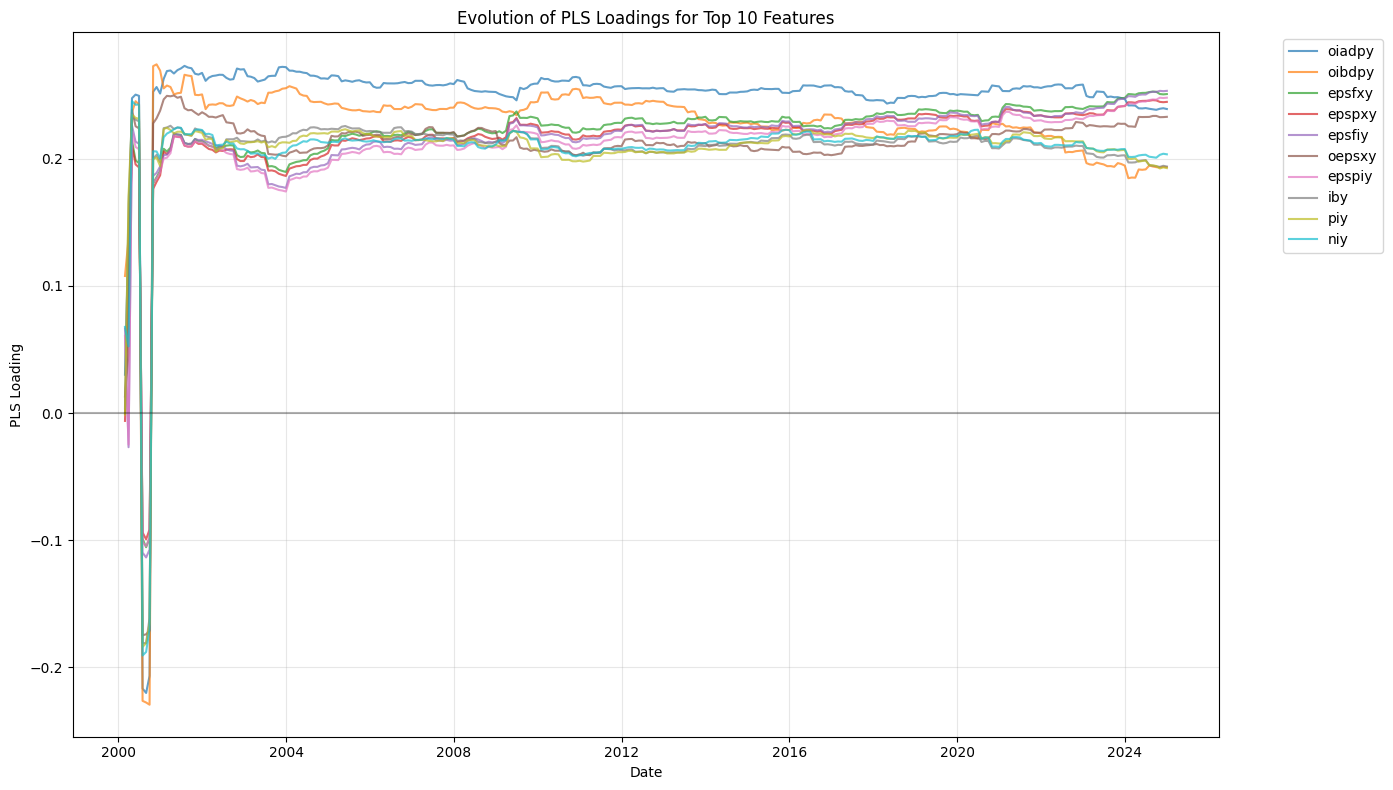

NameError: name 'y_raw' is not defined

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def inspect_pls_models(pls_models, feature_names=None, top_n=20, date_range=None):
    """
    Comprehensive inspection of multiple fitted PLS models (one per date).
    
    Parameters:
    -----------
    pls_models : dict
        Dictionary of fitted PLS models by date from preprocess_characteristics_with_pls
    feature_names : list, optional
        Names of features used in training
    top_n : int, default=20
        Number of top features to display
    date_range : tuple, optional
        (start_date, end_date) to limit analysis to specific dates
    """
    
    if not pls_models:
        print("No PLS models available for inspection")
        return None
    
    # Get sorted dates from the models
    dates = sorted(pls_models.keys())
    
    if date_range:
        dates = [d for d in dates if date_range[0] <= d <= date_range[1]]
        if not dates:
            print(f"No models available in date range {date_range}")
            return None
    
    print(f"Analyzing {len(dates)} PLS models from {dates[0]} to {dates[-1]}")
    
    # Initialize storage for tracking feature importance over time
    all_loadings = []
    
    for date in dates:
        pls_model = pls_models[date]
        
        print("\n" + "=" * 60)
        print(f"MODEL INSPECTION FOR DATE: {date}")
        print("=" * 60)
        
        # Basic model information
        print(f"Number of components: {pls_model.n_components}")
        print(f"Number of features: {pls_model.n_features_in_}")
        
        if hasattr(pls_model, 'feature_names_in_'):
            feature_names = pls_model.feature_names_in_
            print(f"Feature names available: Yes ({len(feature_names)} features)")
        else:
            print("Feature names available: No")
            if feature_names is None:
                feature_names = [f"Feature_{i}" for i in range(pls_model.n_features_in_)]
        
        print()
        
        # X loadings for first component
        x_loadings = pls_model.x_weights_[:, 0]
        
        # Create DataFrame for this date's loadings
        loadings_df = pd.DataFrame({
            'feature': feature_names,
            'loading': x_loadings,
            'abs_loading': np.abs(x_loadings),
            'date': date
        }).sort_values('abs_loading', ascending=False)
        
        all_loadings.append(loadings_df)
        
        # Show top features for this date
        print(f"Top {top_n} most important features:")
        print(loadings_df.head(top_n).to_string(index=False))
        
        # Show loading statistics
        print("\nLOADING STATISTICS:")
        print(f"Mean absolute loading: {np.mean(np.abs(x_loadings)):.4f}")
        print(f"Std of loadings: {np.std(x_loadings):.4f}")
        print(f"Max loading: {np.max(x_loadings):.4f}")
        print(f"Min loading: {np.min(x_loadings):.4f}")
    
    # Combine all loadings for analysis
    combined_loadings = pd.concat(all_loadings)
    
    # Analyze feature stability over time
    print("\n" + "=" * 60)
    print("FEATURE STABILITY ANALYSIS ACROSS DATES")
    print("=" * 60)
    
    # Calculate how often each feature appears in top_n
    top_features_counts = combined_loadings.groupby('feature').apply(
        lambda x: sum(x.groupby('date')['abs_loading'].rank(ascending=False) <= top_n)
    ).sort_values(ascending=False)
    
    print(f"\nFeatures most frequently in top {top_n} across dates:")
    print(top_features_counts.head(20).to_string())
    
    return combined_loadings

def plot_pls_loadings_over_time(combined_loadings, top_features=10, figsize=(14, 8)):
    """
    Plot how PLS loadings evolve over time for top features.
    
    Parameters:
    -----------
    combined_loadings : pd.DataFrame
        Output from inspect_pls_models
    top_features : int, default=10
        Number of top features to track
    figsize : tuple, default=(14, 8)
        Figure size for the plot
    """
    # Get most consistently important features
    feature_stability = combined_loadings.groupby('feature')['abs_loading'].mean().sort_values(ascending=False)
    top_feature_names = feature_stability.head(top_features).index
    
    # Filter and pivot data for plotting
    plot_data = combined_loadings[combined_loadings['feature'].isin(top_feature_names)]
    pivot_data = plot_data.pivot(index='date', columns='feature', values='loading')
    
    # Plot
    plt.figure(figsize=figsize)
    for feature in top_feature_names:
        plt.plot(pivot_data.index, pivot_data[feature], label=feature, alpha=0.7)
    
    plt.title(f'Evolution of PLS Loadings for Top {top_features} Features')
    plt.xlabel('Date')
    plt.ylabel('PLS Loading')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def analyze_pls_index(index_df, returns_df):
    """
    Analyze the relationship between PLS index values and future returns.
    
    Parameters:
    -----------
    index_df : pd.DataFrame
        Output from preprocess_characteristics_with_pls
    returns_df : pd.DataFrame
        Target returns data with columns ['date', 'gvkey', 'MonthlyRet']
    """
    # Merge index with returns
    merged = index_df.merge(returns_df, on=['date', 'gvkey'])
    
    if len(merged) == 0:
        print("No matching data found between index and returns")
        return None
    
    # Calculate overall correlation
    overall_corr = merged['pls_index'].corr(merged['MonthlyRet'])
    print(f"Overall correlation between PLS index and returns: {overall_corr:.4f}")
    
    # Calculate correlation by date
    corr_by_date = merged.groupby('date').apply(
        lambda x: x['pls_index'].corr(x['MonthlyRet'])
    )
    
    print("\nCorrelation statistics by date:")
    print(f"Mean: {corr_by_date.mean():.4f}")
    print(f"Std: {corr_by_date.std():.4f}")
    print(f"Min: {corr_by_date.min():.4f}")
    print(f"Max: {corr_by_date.max():.4f}")
    
    # Plot correlation over time
    plt.figure(figsize=(12, 6))
    corr_by_date.plot()
    plt.title('PLS Index-Return Correlation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(alpha=0.3)
    plt.show()
    
    return merged

# Inspect the models
combined_loadings = inspect_pls_models(pls_model, top_n=25)

# Plot how loadings evolve over time
plot_pls_loadings_over_time(combined_loadings, top_features=10)

# Analyze the index performance
merged_analysis = analyze_pls_index(index_df, y_raw)

In [14]:
index_df.to_csv('Predictors/FirmCharacIndex.csv')

In [16]:
# Calculate correlation
merged = pd.merge(index_df, returns, on=['date', 'gvkey'])
correlation = merged['pls_index'].corr(merged['MonthlyRet'])
print(f"Contemporaneous correlation: {correlation:.4f}")

Contemporaneous correlation: 0.0298
